## Portfolio testing - Main testing period  
In this notebook we aim to test out the different approaches using daily price values, over a range longer than two decades.

In this first section we simply construct the necessary dataframe objects and lists to be able to easily simulate the different strategies over the desired time period. We also clean the data to make sure the indices (Timestamp values) overlap accordingly, to make comparison feasible.

In [ ]:
from pathlib import Path
import pandas as pd

EARLIEST_DATE = "2000-01-01" # we don't take data before this
EARLIEST_DATE = pd.Timestamp(EARLIEST_DATE)

MIN_ROW_COUNT = 4000

# will store metrics of all models used to compare mutually
summary_df = pd.DataFrame(
    columns=[
        "Buy & Hold Index",
        "Equal Weights Assets",
        "Market cap Adj Weights",
        "Exp. Mean reversion",
        "Sharpe optimalization",
        "Periodic Sharpe"
        ],
    index=[
        "Average annual return",
        "Average daily volatility",
        "Sharpe",
        "Sortino",
    ]
)

datapath = Path.cwd() / "data"

colnames_per_sector = [] # list of lists
dfs_per_sector = [] # list of lists

num_sectors = 0
indices_returns = pd.DataFrame()

common_idx = None
for dir in datapath.iterdir():
    if dir.name == "indices":
        for symb in dir.iterdir():
            df = pd.read_csv(datapath / dir / symb, index_col=0)
            df.index = pd.to_datetime(df.index)
            df = df[df.index >= EARLIEST_DATE]
            common_idx = common_idx.intersection(df.index) if common_idx is not None else df.index
            index = symb.name.split('.')[0]
            indices_returns[index] = df["Close"].pct_change()

        continue
    num_sectors += 1
    dfs_this_sector = []
    colnames_this_sector = []
    for symb in dir.iterdir():
        df = pd.read_csv(datapath / dir / symb, index_col=0)
        df.index = pd.to_datetime(df.index)
        df = df[df.index >= EARLIEST_DATE]
        if len(df) < MIN_ROW_COUNT:
            continue
        common_idx = common_idx.intersection(df.index) if common_idx is not None else df.index
        ticker = symb.name.split('.')[0]
        colnames_this_sector.append(ticker)
        dfs_this_sector.append(df)

    dfs_per_sector.append(dfs_this_sector)
    colnames_per_sector.append(colnames_this_sector)

final_colnames = [] # list of ticker names per sector
returns_list = [] # list of dataframes of returns per ticker within one sector
# list of returns per ticker, but only ones that have a marketcap column
# we need this for a later approach
returns_list_filtered = []
final_colnames_filtered = []
market_cap_list = []


for sector_dfs, sector_colnames in zip(dfs_per_sector, colnames_per_sector):
    final_colnames_this_sector = []
    final_df_data_this_sector = pd.DataFrame()
    final_colnames_filtered_sector = []
    market_data_filtered = pd.DataFrame()
    final_returns_this_sector_filtered = pd.DataFrame()
    for df, colname in zip(sector_dfs, sector_colnames):
        df = df[df.index.isin(common_idx)]
        if len(df) < MIN_ROW_COUNT:
            continue
        final_df_data_this_sector[colname] = df["Close"].pct_change()
        final_colnames_this_sector.append(colname)

        if "MarketCap" in df.columns:
            final_colnames_filtered_sector.append(colname)
            market_data_filtered[colname] = df["MarketCap"]
            final_returns_this_sector_filtered[colname] = df["Close"].pct_change()

    final_colnames.append(final_colnames_this_sector)
    returns_list.append(final_df_data_this_sector)

    market_cap_list.append(market_data_filtered)
    final_colnames_filtered.append(final_colnames_filtered_sector)
    returns_list_filtered.append(final_returns_this_sector_filtered)

indices_returns = indices_returns[indices_returns.index.isin(common_idx)]

all_returns_df = pd.DataFrame(index=indices_returns.index)

### Strategy 1 - Equal weights
Equal weights accross all tickers, stocks only. Each sector also holds the same weight.

            pf_daily_returns  pf_cum_returns  ann_volatility  mon_volatility
Date                                                                        
2009-08-06               NaN             NaN             NaN             NaN
2009-08-07          0.019204        0.019204             NaN             NaN
2009-08-10         -0.004242        0.014881             NaN             NaN
2009-08-11         -0.011773        0.002933             NaN             NaN
2009-08-12          0.012111        0.015079             NaN             NaN
...                      ...             ...             ...             ...
2025-09-15         -0.001929       10.161879        0.010492        0.006307
2025-09-16         -0.000373       10.157719        0.010479        0.006015
2025-09-17          0.000796       10.166598        0.010479        0.005998
2025-09-18          0.003677       10.207652        0.010480        0.005951
2025-09-19         -0.001504       10.190794        0.010477        0.005972

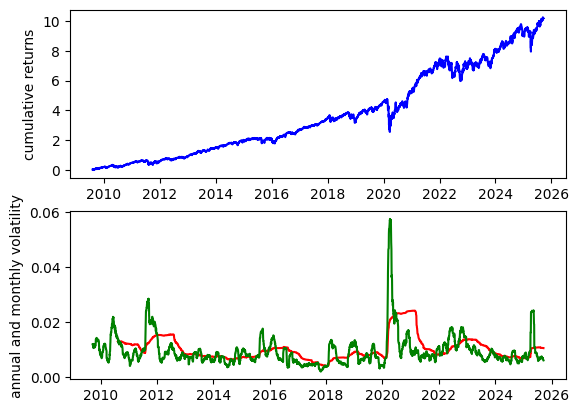

In [3]:
import numpy as np
import matplotlib.pyplot as plt

num_rows = len(returns_list[0])
num_sectors = len(returns_list)

returns_vector = np.zeros(num_rows)
for return_df in returns_list:
    mean_returns = return_df.mean(axis=1) # equal weights within one sector
    returns_vector += mean_returns.values

returns_vector /= num_sectors # normalize to make sure the sum is one

pf1 = pd.DataFrame({
    "pf_daily_returns": returns_vector,
    }, index=returns_list[0].index)

pf1["pf_cum_returns"] = (1 + pf1["pf_daily_returns"]).cumprod() - 1
pf1["ann_volatility"] = pf1["pf_daily_returns"].rolling(255).std()
pf1["mon_volatility"] = pf1["pf_daily_returns"].rolling(30).std()

print(pf1)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(pf1.index, pf1["pf_cum_returns"], color="blue", label="cumulative_returns")
ax1.set_ylabel('cumulative returns')

ax2.plot(pf1.index, pf1["ann_volatility"], color="red", label="ann_volatility")
ax2.plot(pf1.index, pf1["mon_volatility"], color="green", label="mon_volatility")
ax2.set_ylabel('annual and monthly volatility')

risk_free = 0.0
sharpe = (pf1["pf_daily_returns"].mean() * 255 - risk_free) / (pf1["pf_daily_returns"].std() * np.sqrt(255))
sortino = (pf1["pf_daily_returns"].mean() * 255 - risk_free) / (pf1[pf1["pf_daily_returns"] < 0]["pf_daily_returns"].std() * np.sqrt(255))

avg_daily_vola = pf1["pf_daily_returns"].std()
avg_ann_return = pf1["pf_daily_returns"].mean() * 255

print('sharpe:', sharpe)
print('sortino:', sortino)
print('average daily volatility:', avg_daily_vola)
print('average annual return:', avg_ann_return)

summary_df["Equal Weights Assets"] = [avg_ann_return, avg_daily_vola, sharpe, sortino]

all_returns_df["Equal Weights Assets"] = pf1["pf_cum_returns"]

plt.show()

### Strategy 2 - Buy & Hold the S&P500
Buy & Hold the overall market. No individual stocks, just the S&P index.

sharpe: 0.7798400916229786
sortino: 0.9637495785451737
average daily volatility: 0.010947787128399918
average annual return: 0.13633331441816246


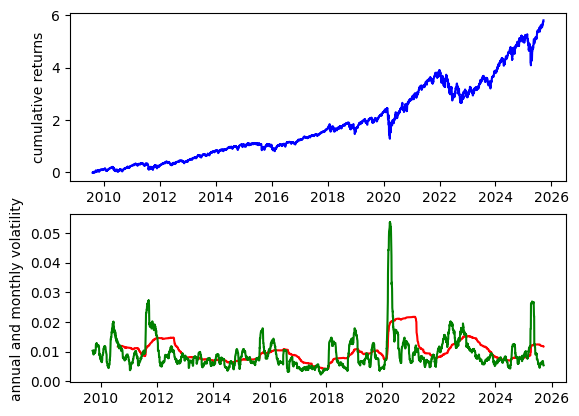

In [4]:
pf2 = pd.DataFrame({
    "pf_daily_returns": indices_returns["^GSPC"],
    "pf_cum_returns": (1 + indices_returns["^GSPC"]).cumprod() - 1,
    "ann_volatility": indices_returns["^GSPC"].rolling(255).std(),
    "mon_volatility": indices_returns["^GSPC"].rolling(30).std()
    }, index=indices_returns["^GSPC"].index)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(pf1.index, pf2["pf_cum_returns"], color="blue", label="cumulative_returns")
ax1.set_ylabel('cumulative returns')

ax2.plot(pf1.index, pf2["ann_volatility"], color="red", label="ann_volatility")
ax2.plot(pf1.index, pf2["mon_volatility"], color="green", label="mon_volatility")
ax2.set_ylabel('annual and monthly volatility')

risk_free = 0.0
sharpe = (pf2["pf_daily_returns"].mean() * 255 - risk_free) / (pf2["pf_daily_returns"].std() * np.sqrt(255))
sortino = (pf2["pf_daily_returns"].mean() * 255 - risk_free) / (pf2[pf2["pf_daily_returns"] < 0]["pf_daily_returns"].std() * np.sqrt(255))
avg_ann_return = pf2["pf_daily_returns"].mean() * 255
avg_daily_vola = pf2["pf_daily_returns"].std()

print('sharpe:', sharpe)
print('sortino:', sortino)
print('average daily volatility:', avg_daily_vola)
print('average annual return:', avg_ann_return)

summary_df["Buy & Hold Index"] = [avg_ann_return, avg_daily_vola, sharpe, sortino]

all_returns_df["Buy & Hold Index"] = pf2["pf_cum_returns"]

plt.show()

### Strategy 3 - Market cap adjusted weights  
Market cap adjusted weights, only stocks. Companies with a greater market cap get a greater weight allocation. The philosophy behind this method is that bigger companies often are more stable and experience less speculation and risky behaviour.  
The weight for ticker $i$ at time $t$ within a specific sector gets calculated as:  
$w_{i,t}=M_{i,t}/(\sum_{j\in\text{sector of i}}M_{j,t})/N$  
with $M_{i,t}$ being the market cap of ticker $i$ at time $t$ and $N$ being the amount of sectors. This ensures weights within a sector sum to $1/N$, and all weights sum to 1.

            pf_daily_returns  pf_cum_returns  ann_volatility  mon_volatility
Date                                                                        
2009-08-06          0.000000        0.000000             NaN             NaN
2009-08-07          0.014502        0.014502             NaN             NaN
2009-08-10         -0.005495        0.008928             NaN             NaN
2009-08-11         -0.011818       -0.002995             NaN             NaN
2009-08-12          0.011268        0.008239             NaN             NaN
...                      ...             ...             ...             ...
2025-09-15          0.002916       14.951733        0.009573        0.004724
2025-09-16         -0.001002       14.935749        0.009555        0.004427
2025-09-17          0.001228       14.955318        0.009554        0.004410
2025-09-18          0.001563       14.980257        0.009551        0.004408
2025-09-19          0.001700       15.007428        0.009544        0.004385

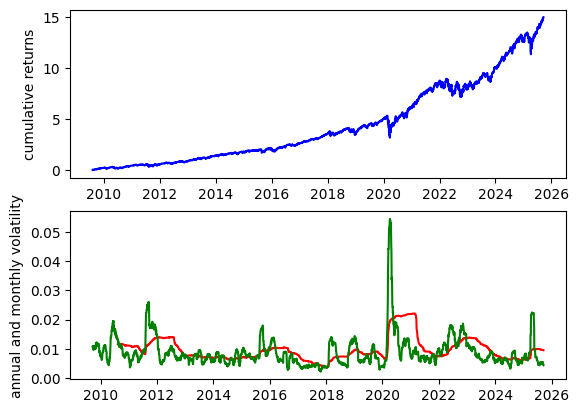

In [5]:

num_sectors_with_marketcap = len(market_cap_list)

pf_returns = np.zeros(num_rows)
for market_cap_matrix, ticker_names, returns_df in zip(
    market_cap_list, final_colnames_filtered, returns_list_filtered
    ):
    sum_market_caps = market_cap_matrix.sum(axis=1)
    weight_matrix = market_cap_matrix.div(sum_market_caps, axis=0)
    weight_matrix /= num_sectors_with_marketcap
    this_sector_return = (weight_matrix * returns_df).sum(axis=1)
    pf_returns += this_sector_return.values

pf_returns = pd.Series(pf_returns, index=returns_df.index)

pf3 = pd.DataFrame({
    "pf_daily_returns": pf_returns,
    "pf_cum_returns": (1 + pf_returns).cumprod() - 1,
    "ann_volatility": pf_returns.rolling(255).std(),
    "mon_volatility": pf_returns.rolling(30).std(),
    }, index=pf_returns.index)

print(pf3)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(pf3.index, pf3["pf_cum_returns"], color="blue", label="cumulative_returns")
ax1.set_ylabel('cumulative returns')

ax2.plot(pf1.index, pf3["ann_volatility"], color="red", label="ann_volatility")
ax2.plot(pf1.index, pf3["mon_volatility"], color="green", label="mon_volatility")
ax2.set_ylabel('annual and monthly volatility')

risk_free = 0.0
sharpe = (pf3["pf_daily_returns"].mean() * 255 - risk_free) / (pf3["pf_daily_returns"].std() * np.sqrt(255))
sortino = (pf3["pf_daily_returns"].mean() * 255 - risk_free) / (pf3[pf3["pf_daily_returns"] < 0]["pf_daily_returns"].std() * np.sqrt(255))
avg_daily_vola = pf3["pf_daily_returns"].std()
avg_ann_return = pf3["pf_daily_returns"].mean() * 255
print('sharpe:', sharpe)
print('sortino:', sortino)
print('average daily volatility:', avg_daily_vola)
print('average annual return:', avg_ann_return)

summary_df["Market cap Adj Weights"] = [avg_ann_return, avg_daily_vola, sharpe, sortino]

all_returns_df["Market cap Adj Weights"] = pf3["pf_cum_returns"]

plt.show()

### Strategy 4 - (Experimental) mean-reversion  
In this strategy we use a mean-reversion sort of approach, where we compare the relative momentum of a specific asset within a sector to the relative momentum of the entire market. I define the relative momentum of asset $i$ at time $t$ as  
$R_{t,i}=(r_{t,i}-m_{[t-T,t],i})/(M_{[t-T,t],i}-m_{[t-T,t],i})$  
where $m_{[t-T,t],i}$ is the minimum return value in the interval $[t-T,t]$, with $T$ being the lookback period, and $M_{[t-T,t],i}$ similarly being the maximum, and $r_{t,i}$ being the return of asset $i$ at timestamp $t$, so this is just the normalized relative return. We then determine the weights per asset as  
$w_{t,i}=M_t/R_{t,i}$  
with $M_t$ being the relative momentum of the market (index), and we then normalize it such that each sector's allocation is the same and the weights sum to 1. So if the asset is underperforming the market (in the short term) its weight gets increased, with the belief that the asset will correlate with the market again in the near future.  
I realise that this method isn't standard in the portfolio modeling world - it is safe to say that I have not seen this approach being used somewhere yet. However, is is my goal using this method to try out something new and to see how it performs in comparison to other models.

In [6]:
PERIOD = 30
rel_momentum_dfs = []

for returns in returns_list:
    rel_momentum = pd.DataFrame()
    for col in returns.columns:
        rolling_max = returns[col].rolling(PERIOD, min_periods=10).max()
        rolling_min = returns[col].rolling(PERIOD, min_periods=10).min()
        rel_mom = (returns[col] - rolling_min) / (rolling_max - rolling_min)
        rel_momentum[col] = rel_mom
    rel_momentum_dfs.append(rel_momentum)

snp = indices_returns["^GSPC"]
rolling_max = snp.rolling(PERIOD, min_periods=10).max()
rolling_min = snp.rolling(PERIOD, min_periods=10).min()
rel_momentum_snp = (snp - rolling_min) / (rolling_max - rolling_min + 1e-08)

norm_weights_matrix = []

for rel_df in rel_momentum_dfs:
    weights = rel_df.rdiv(rel_momentum_snp, axis=0)
    sum_weights = weights.sum(axis=1)
    res_weights = weights.div(sum_weights, axis=0).div(num_sectors)
    norm_weights_matrix.append(res_weights)

returns_vector = np.zeros(norm_weights_matrix[0].shape[0])
for returns, weight_m in zip(returns_list, norm_weights_matrix):
    r = (returns * weight_m).sum(axis=1).values
    returns_vector += r

print(returns_vector)


[ 0.          0.          0.         ... -0.00180932  0.00058957
 -0.00217242]


sharpe: 1.2657909972023356
sortino: 2.376803476291836
average daily volatility: 0.007463553331356355
average annual return: 0.15086126086868448


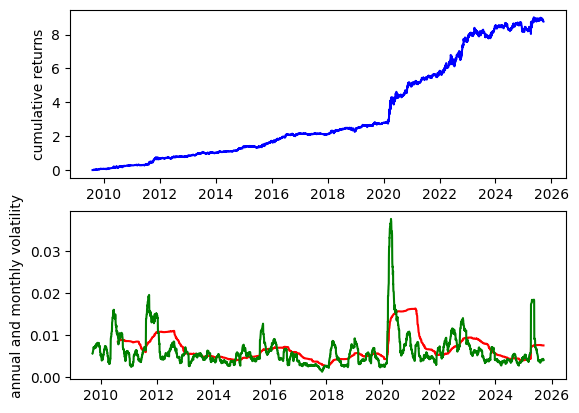

In [7]:
returns_vector = pd.Series(returns_vector, index=norm_weights_matrix[0].index)

pf4 = pd.DataFrame({
    "pf_daily_returns": returns_vector,
    "pf_cum_returns": (1 + returns_vector).cumprod() - 1,
    "ann_volatility": returns_vector.rolling(255).std(),
    "mon_volatility": returns_vector.rolling(30).std()
    }, index=norm_weights_matrix[0].index)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(pf4.index, pf4["pf_cum_returns"], color="blue", label="cumulative_returns")
ax1.set_ylabel('cumulative returns')

ax2.plot(pf4.index, pf4["ann_volatility"], color="red", label="ann_volatility")
ax2.plot(pf4.index, pf4["mon_volatility"], color="green", label="mon_volatility")
ax2.set_ylabel('annual and monthly volatility')

import numpy as np

risk_free = 0.0
sharpe = (pf4["pf_daily_returns"].mean() * 255 - risk_free) / (pf4["pf_daily_returns"].std() * np.sqrt(255))
sortino = (pf4["pf_daily_returns"].mean() * 255 - risk_free) / (pf4[pf4["pf_daily_returns"] < 0]["pf_daily_returns"].std() * np.sqrt(255))
avg_daily_vola = pf4["pf_daily_returns"].std()
avg_ann_return = pf4["pf_daily_returns"].mean() * 255
print('sharpe:', sharpe)
print('sortino:', sortino)
print('average daily volatility:', avg_daily_vola)
print('average annual return:', avg_ann_return)

summary_df["Exp. Mean reversion"] = [avg_ann_return, avg_daily_vola, sharpe, sortino]

all_returns_df["Exp. Mean reversion"] = pf4["pf_cum_returns"]

plt.show()

### Strategy 5 - Asset weight determination using sharpe ratio optimalization  
Here, we determine static weights (once for the testing period) by maximizing the Sharpe ratio function:  
$f(w)=(\mu^Tw-\text{rf})/\sqrt{w^T\Sigma w}$  
where $w$ is a vector of length the amount of assets and "rf" is the risk-free rate. The given parameters of the function are the mean returns per asset $\mu$ and the covariance matrix between the asset returns $\Sigma$.  
We split the dataframe of returns into two parts, yielding a training and a testing set, whose size is determined by the "training_pct_data" parameter, and we then use the optimized weights yielded by optimizing the Sharpe ratio function over the training data, and using these weights for the testing data.

sharpe: 0.9031952607932101
sortino: 1.2698296788303414
average daily volatility: 0.008619605366154833
average annual return: 0.12431946233079282


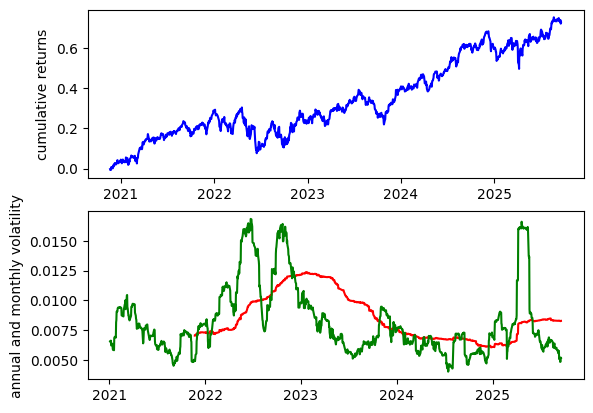

In [8]:
from scipy.optimize import minimize

BOOTSTRAP_WINDOW = 365
num_rows = len(returns_list[0])

TRAINING_PCT_DATA = 0.7 # eg. 70%

def optimize(df_section, risk_free=0):
    # df_section is a dataframe of length BOOTSTRAP_WINDOW with the columns being all the assets
    cov = np.cov(df_section, rowvar=False)
    mean_returns = df_section.mean(axis=0)

    n_assets = len(mean_returns)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))

    def sharpe_performance(weights):
        return (np.dot(mean_returns, weights) - risk_free) / np.sqrt(weights.T @ cov @ weights)

    def neg_sharpe(weights):
        return -sharpe_performance(weights)

    x0 = np.ones(n_assets) / n_assets
    
    return minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=constraints).x

all_returns = pd.DataFrame(index=returns_list[0].index)
struct = np.empty((num_rows, sum([len(rdf.columns) for rdf in returns_list])))
i = 0
for returns_df in returns_list:
    for col in returns_df.columns:
        struct[:,i] = returns_df[col]
        i += 1

all_returns = pd.DataFrame(struct, index=returns_list[0].index).iloc[1:]

training_data = all_returns.iloc[:int(TRAINING_PCT_DATA * len(all_returns))]
test_data = all_returns.iloc[int(TRAINING_PCT_DATA * len(all_returns)):]
num_rows_training_data = len(training_data)

resulting_weights = []

for idx in range(BOOTSTRAP_WINDOW, num_rows_training_data, BOOTSTRAP_WINDOW):
    df_section = training_data.iloc[:idx]
    #print('df section'); print(df_section)
    weights = optimize(df_section)
    #print('current weights:', weights)
    resulting_weights.append(weights)

resulting_weights = np.array(resulting_weights)
final_weights = resulting_weights.mean(axis=0)

ret = np.matmul(test_data.values, final_weights)

ret = pd.Series(ret, index=test_data.index)

pf5 = pd.DataFrame({
    'pf_daily_returns': ret,
    'pf_cum_returns': (1 + ret).cumprod() - 1,
    'ann_volatility': ret.rolling(255).std(),
    'mon_volatility': ret.rolling(30).std()
})

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(pf5.index, pf5["pf_cum_returns"], color="blue", label="cumulative_returns")
ax1.set_ylabel('cumulative returns')

ax2.plot(pf5.index, pf5["ann_volatility"], color="red", label="ann_volatility")
ax2.plot(pf5.index, pf5["mon_volatility"], color="green", label="mon_volatility")
ax2.set_ylabel('annual and monthly volatility')

risk_free = 0.0
sharpe = (pf5["pf_daily_returns"].mean() * 255 - risk_free) / (pf5["pf_daily_returns"].std() * np.sqrt(255))
sortino = (pf5["pf_daily_returns"].mean() * 255 - risk_free) / (pf5[pf5["pf_daily_returns"] < 0]["pf_daily_returns"].std() * np.sqrt(255))
avg_daily_vola = pf5["pf_daily_returns"].std()
avg_ann_return = pf5["pf_daily_returns"].mean() * 255
print('sharpe:', sharpe)
print('sortino:', sortino)
print('average daily volatility:', avg_daily_vola)
print('average annual return:', avg_ann_return)

summary_df["Sharpe optimalization"] = [avg_ann_return, avg_daily_vola, sharpe, sortino]

all_returns_df["Sharpe optimalization"] = pf5["pf_cum_returns"]

plt.show()




### Strategy 6 - Periodic reballancing of weights, using maximalization of the Sharpe ratio
Here we implement a similar approach as in the last method, but here we rebalance the weights every few months for example. This aims to make the weight distribution more consistent over time. The rebalancing time period gets determined by the "stepsize" parameter.  
Because our data is quite limited, this simulation could be considered quite lacking in terms of consistency. We only have 7 frames for example, when we choose the "stepsize" to be 500, and if we choose the training percentage of our data to be eg. 70%, then our training data can only be around 1 year while the testing data is 150 trading days in this case.

   daily_vola  ann_mean_return    sharpe   sortino
0    0.011208         0.411566  2.299583  3.582368
1    0.009802         0.168199  1.074590  1.784345
2    0.011103         0.445263  2.511263  3.554761
3    0.007149         0.203033  1.778592  2.440491
4    0.011807         0.448050  2.376475  3.394545
5    0.007977         0.017180  0.134864  0.198499
6    0.011387         0.222130  1.221550  1.533243


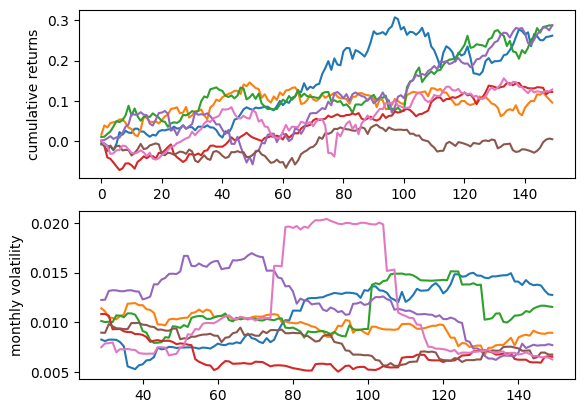

In [9]:
from scipy.optimize import minimize

STEPSIZE = 500 # eg. 500 days
TRAINING_PCT_DATA = 0.7
num_rows = len(returns_list[0])

def optimize(df_section, risk_free=0):
    # df_section is a dataframe of length BOOTSTRAP_WINDOW with the columns being all the assets
    cov = np.cov(df_section, rowvar=False)
    mean_returns = df_section.mean(axis=0)

    n_assets = len(mean_returns)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))

    def sharpe_performance(weights):
        return (np.dot(mean_returns, weights) - risk_free) / np.sqrt(weights.T @ cov @ weights)

    def neg_sharpe(weights):
        return -sharpe_performance(weights)

    x0 = np.ones(n_assets) / n_assets
    
    return minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=constraints).x

all_returns = pd.DataFrame(index=returns_list[0].index)
struct = np.empty((num_rows, sum([len(rdf.columns) for rdf in returns_list])))
i = 0
for returns_df in returns_list:
    for col in returns_df.columns:
        struct[:,i] = returns_df[col]
        i += 1

all_returns = pd.DataFrame(struct, index=returns_list[0].index).iloc[1:]

fig, axs = plt.subplots(2)

stats_matrix = []

sum_sortinos = 0
sum_sharpes = 0
sum_daily_volatilities = 0
sum_ann_returns = 0

risk_free = 0.0
for i, idx in enumerate(range(STEPSIZE, num_rows, STEPSIZE)):
    if idx + STEPSIZE >= num_rows:
        break
    df_section = all_returns.iloc[idx:idx + STEPSIZE]
    train_section = all_returns.iloc[idx:idx + int(TRAINING_PCT_DATA * STEPSIZE)]
    test_section = all_returns.iloc[idx + int(TRAINING_PCT_DATA * STEPSIZE): idx + STEPSIZE]
    weights = optimize(train_section)
    ret = np.matmul(test_section.values, weights)
    ret = pd.Series(ret, index=test_section.index)
    cum_ret = (1 + ret).cumprod() - 1

    axs[0].plot(list(range(len(cum_ret))), cum_ret, label="cumulative returns")
    axs[1].plot(list(range(len(cum_ret))), ret.rolling(30).std(), label="monthly volatility")
    axs[0].set_ylabel('cumulative returns')
    axs[1].set_ylabel('monthly volatility')
    daily_vola = ret.std()
    ann_mean_return = ret.mean() * 255
    sharpe = (ann_mean_return - risk_free) / (daily_vola * np.sqrt(255))
    sortino = (ann_mean_return - risk_free) / (ret[ret < 0].std() * np.sqrt(255))

    sum_sortinos += sortino
    sum_sharpes += sharpe
    sum_ann_returns += ann_mean_return
    sum_daily_volatilities += daily_vola

    stats_matrix.append([daily_vola, ann_mean_return, sharpe, sortino])
    
stats_matrix = pd.DataFrame(stats_matrix, index=list(range(len(stats_matrix))),
    columns=["daily_vola", "ann_mean_return", "sharpe", "sortino"])

print(stats_matrix)

mean_sortino = sum_sortinos / i
mean_sharpes = sum_sharpes / i
mean_ann_returns = sum_ann_returns / i
mean_daily_vola = sum_daily_volatilities / i

summary_df["Periodic Sharpe"] = [mean_ann_returns, mean_daily_vola, mean_sharpes, mean_sortino]

plt.show()

    




                          Buy & Hold Index  Equal Weights Assets  \
Average annual return             0.136333              0.168113   
Average daily volatility          0.010948              0.011063   
Sharpe                            0.779840              0.951635   
Sortino                           0.963750              1.167315   

                          Market cap Adj Weights  Exp. Mean reversion  \
Average annual return                   0.188868             0.150861   
Average daily volatility                0.010412             0.007464   
Sharpe                                  1.135902             1.265791   
Sortino                                 1.388743             2.376803   

                          Sharpe optimalization  Periodic Sharpe  
Average annual return                  0.124319         0.273632  
Average daily volatility               0.008620         0.010062  
Sharpe                                 0.903195         1.628131  
Sortino                  

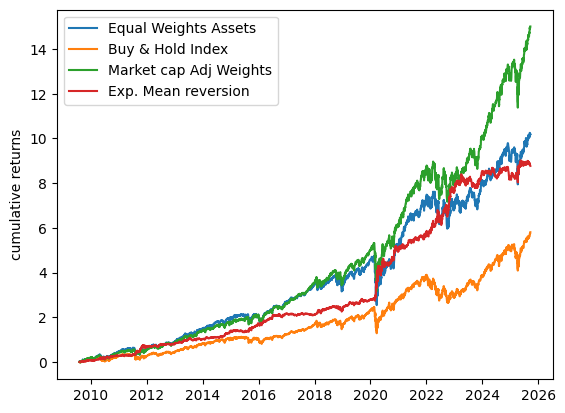

In [10]:
print(summary_df)

fig, ax = plt.subplots()

for colname in all_returns_df.columns[:-1]:
    ax.plot(all_returns_df.index, all_returns_df[colname], label=colname)

ax.set_ylabel('cumulative returns')
ax.legend()

plt.show()

### Conclusion
In this backtest simulation, I conclude that the market-cap adjusted weights model performed the best, with equal weights and the experimental mean-reversion performing the second and third best. Surprisingly, buying & holding the general market udnerperformed all of these "active" investment strategies.
Some caveats and interesting things I've noticed:

-The fact that the market-cap adjusted weights strategy has performed so well, I think is due to the very large-cap (tech) stocks that have soared in recent history, and this strategy might not represent a clear picture during times where this is less the case. So this might be an outlier biased in recent history (and probably is).

-The fact that equal-weights on individual assets outperformed the general market I believe is also due to the rise of large-cap stocks in comparison to lower-cap companies.

-The experimental mean-reversion performed very well during the 2008 financial crash. I believe this is because the very method implies that the assets that have performed the worst in the recent past get allocated more weights, meaning we are "buying" more in the biggest dip. However, I've not tested this method anywhere else, for example in other financial crashes, so this might be a coincidence.

-In this simulation I've only used data from the year 2000 onwards, and only a limited amount of assets. Unfortunately some stock datasets don't have a sophisticated range of price levels, so I had to discard them (in the data cleaning phase). This might have contributed to less precise equal-weight strategy results for example.
